In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from invert import invert_ebb, invert_msp, load_source_time_series
from simulate import run_dipole_simulation
from laminar import sliding_window_model_comparison, model_comparison
from matplotlib import colors
from scipy.interpolate import interp1d
import elephant
import neo
import quantities as pq

In [2]:
def csd_calc(signal, thickness, sfreq):
    """
    signal - contact x time
    thickness - overall in mm
    sampling rate - in Hz
    """
    sig = neo.core.AnalogSignal(
        signal.T, units="T", sampling_rate=sfreq*pq.Hz
    )
    th = pq.Quantity(np.linspace(0, thickness, num=11).reshape(-1,1)) * pq.mm
    csd_est = elephant.current_source_density.estimate_csd(
        sig, th,
        method = "StandardCSD"
    )
    return csd_est.as_array().T

def csd_smooth(csd, layers=11, kind="cubic"):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind=kind)
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed
  
# visualisation
def plot_spaced_signal(signal, times, ax):
    v_contacts = signal.shape[0]
    cm = plt.colormaps["rainbow"]
    cm_l = cm(np.linspace(0,1, num=v_contacts))[:,:3]
    max_amp = np.abs(signal).max()
    max_amp = max_amp + max_amp*0.05
    spacing = np.linspace(0, max_amp * v_contacts, num=v_contacts)
    vis_signal = signal + spacing.reshape(-1,1)
    for ix, vs in enumerate(vis_signal):
        ax.plot(times, vs, lw=1, c=cm_l[ix])
    ax.set_yticks(spacing)
    ax.set_yticklabels(np.arange(1,v_contacts+1)[::-1])
    ax.set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)
    
 
    
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, return_details=False):
#     layer_labels = ["I", "II", "III", "IV", "V", "VI"]
#     with open(bb_path, "r") as fp:
#         bb = json.load(fp)
#     bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
#     bb_mean = [np.mean(i) for i in bb]
#     bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    elif vmin_vmax == "norm":
        divnorm = colors.Normalize()
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 0, 1]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    #ax.set_yticks(np.linspace(0,1, num=info["layers"]))
    ax.set_yticklabels(np.arange(1,12))
    layers_params = []
#     for l_ix, th in enumerate(np.cumsum(bb_mean)):
#         ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
#         ax.annotate(layer_labels[l_ix],[times[0]+0.06, th-0.01], size=15, ha='left')
#         layers_params.append([th, layer_labels[l_ix]])
    if cb:
        clbr=plt.colorbar(csd_imshow, ax=ax)
        clbr.set_label('CSD')
    plt.tight_layout()
    if return_details:
        return layers_params, csd_imshow

In [3]:
sim_vertex=420
sim_patch_size=5
dipole_moment=10
SNR=-5
n_layers=11
layers = np.linspace(1, 0, n_layers)
signal_width=.025 # 25ms

data_dir='./test_data'
out_dir='./test_output'
tmp_dir='/scratch/bonaiuto/simulated_data/'
subj_id='sub-104'
ses_id='ses-01'
# Subject fiducial coil coordinates
nas=[0.9662503311032098, 108.83514306876269, 1.6712361927090313]
lpa=[-74.28671169006893, 20.15061014698176, -29.849056272705948]
rpa=[76.02110531729883, 18.9467849625573, -25.779407159603114]

# T1
mri_fname = os.path.join(data_dir,'spm', subj_id, 's2023-02-28_13-33-133958-00001-00224-1.nii')

mesh_fname = os.path.join(out_dir, subj_id, 'multilayer.11.ds.link_vector.gii')

## Create intermediate surfaces if needed
layer_fnames = []
for l, layer in enumerate(layers):
    if layer == 1:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'pial.ds.link_vector.gii'))
    elif layer > 0 and layer < 1:
        layer_name = '{:.3f}'.format(layer)
        layer_fnames.append(os.path.join(out_dir, subj_id, f'{layer_name}.ds.link_vector.gii'))        
    elif layer == 0:
        layer_fnames.append(os.path.join(out_dir, subj_id, 'white.ds.link_vector.gii'))

# Data file to base simulations on
data_file=os.path.join(data_dir, 'processed', subj_id, ses_id, 'spm/pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat')

patch_size=5
n_temp_modes = 4
win_size=10
win_overlap=True

mesh=nib.load(mesh_fname)
verts_per_surf=int(mesh.darrays[0].data.shape[0]/n_layers)
layer_verts=[l*verts_per_surf+sim_vertex for l in range(n_layers)]
subject_out_dir = os.path.join(out_dir, subj_id, 'inv')

In [4]:
layer_coords=mesh.darrays[0].data[layer_verts,:]
layer_dists=np.sqrt(np.sum(np.diff(layer_coords,axis=0)**2,axis=1))

In [5]:
layer_dists

array([0.35062027, 0.34773663, 0.34771544, 0.3477091 , 0.3476935 ,
       0.34769568, 0.3476823 , 0.3476773 , 0.34764224, 0.34899572],
      dtype=float32)

In [6]:
# Invert the subject's data. This step only has to be done once
# [base_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, data_file, n_layers, 
#                             patch_size=patch_size, n_temp_modes=n_temp_modes)

In [7]:
base_fname='/scratch/bonaiuto/simulated_data/multilayer.11.ds.link_vector.pspm-converted_autoreject-sub-104-ses-01-001-btn_trial-epo.mat'

Text(0, 0.5, 'Amplitude (normalised)')

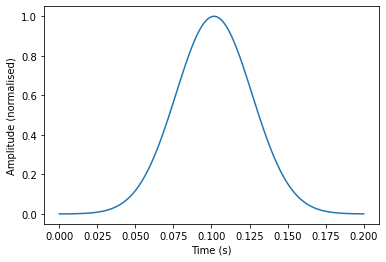

In [8]:
time=np.linspace(0,.2,121)
zero_time=time[int((len(time)-1)/2+1)]

signal=np.exp(-((time-zero_time)**2)/(2*signal_width**2))

plt.figure()
plt.plot(time,signal)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalised)')

In [9]:
pial_vertex=sim_vertex
white_vertex=(n_layers-1)*int(verts_per_surf)+sim_vertex
mid_vertex=5*int(verts_per_surf)+sim_vertex

pial_unit_norm=mesh.darrays[2].data[pial_vertex,:]
mid_unit_norm=mesh.darrays[2].data[mid_vertex,:]
white_unit_norm=-1*mesh.darrays[2].data[white_vertex,:]

In [10]:
prefix=f'sim_{sim_vertex}_superficial.'
pial_sim_fname=run_dipole_simulation(base_fname, prefix, pial_vertex, signal, pial_unit_norm, dipole_moment, 
                                     sim_patch_size, SNR)    

In [11]:
[inv_pial_sim_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, pial_sim_fname, n_layers, 
                                    patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


In [12]:
layer_ts=load_source_time_series(inv_pial_sim_fname, inv_pial_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


/home/bonaiuto/miniconda3/envs/megsurfer_matlab/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator


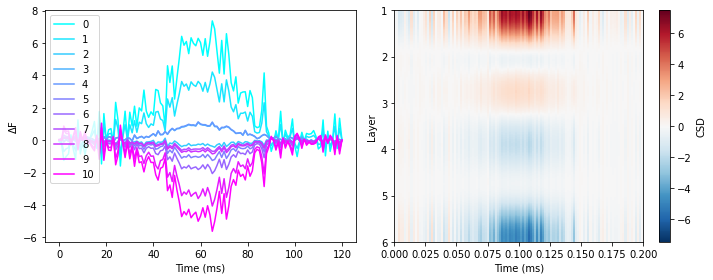

In [13]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


/home/bonaiuto/miniconda3/envs/megsurfer_matlab/lib/python3.6/site-packages/ipykernel_launcher.py:68: UserWarning: FixedFormatter should only be used together with FixedLocator


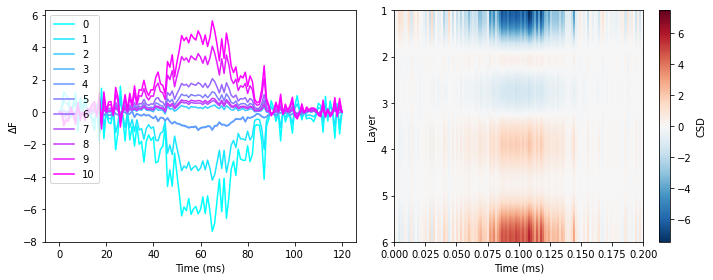

In [14]:
csd=csd_calc(-1*layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [15]:
prefix=f'sim_{sim_vertex}_deep.'
white_sim_fname=run_dipole_simulation(base_fname, prefix, white_vertex, signal, white_unit_norm, dipole_moment, 
                                      sim_patch_size, SNR)    

In [16]:
[inv_white_sim_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, white_sim_fname, n_layers, 
                                    patch_size=patch_size, n_temp_modes=n_temp_modes)

Smoothing ./test_output/sub-104/multilayer.11.ds.link_vector.gii
FWHM of 5.00 is approx 3.33 times vertex spacing


TypeError: 'NoneType' object is not iterable

In [ ]:
layer_ts=load_source_time_series(inv_white_sim_fname, inv_white_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

In [ ]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
csd=csd_calc(-1*layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
prefix=f'sim_{sim_vertex}_mid.'
mid_sim_fname=run_dipole_simulation(base_fname, prefix, mid_vertex, signal, mid_unit_norm, dipole_moment, 
                                    sim_patch_size, SNR)    

In [ ]:
[inv_mid_sim_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, mid_sim_fname, n_layers, 
                                   patch_size=patch_size, n_temp_modes=n_temp_modes)

In [ ]:
layer_ts=load_source_time_series(inv_mid_sim_fname, inv_mid_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

In [ ]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
csd=csd_calc(-1*layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
deep_width=.025
superficial_width=.01
deep_signal=np.exp(-((time-zero_time)**2)/(2*deep_width**2))
superficial_signal=np.exp(-((time-zero_time)**2)/(2*superficial_width**2))

sim_pos=[white_vertex, pial_vertex]
# Orientation of each dipole
sim_ori=np.vstack([white_unit_norm, pial_unit_norm])
# Dipole momemnts
sim_dipmom=[6, 8] # nAm
# Combined signal
sim_signal=np.vstack([deep_signal, superficial_signal])
# Width of patch
sim_dipfwhm=[5, 5] # mm
    

prefix=f'sim_{sim_vertex}_burst.'
burst_sim_fname=run_dipole_simulation(base_fname, prefix, sim_pos, sim_signal, sim_ori, sim_dipmom, sim_dipfwhm, SNR)    

In [ ]:
plt.figure()
plt.plot(time,superficial_signal, label='superficial')
plt.plot(time,deep_signal, label='deep')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalised)')

In [ ]:
[inv_burst_sim_fname,F,_]=invert_ebb(tmp_dir, nas, lpa, rpa, mri_fname, mesh_fname, burst_sim_fname, n_layers, 
                                     patch_size=patch_size, n_temp_modes=n_temp_modes)

In [ ]:
layer_ts=load_source_time_series(inv_burst_sim_fname, inv_burst_sim_fname, vertices=layer_verts)
layer_ts=np.array(layer_ts)
csd=csd_calc(layer_ts,.01,600)
smooth_csd=csd_smooth(csd)

In [ ]:
col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()

In [ ]:
csd=csd_calc(-1*layer_ts,np.mean(layer_dists),600)
smooth_csd=csd_smooth(csd)

col_r = plt.cm.cool(np.linspace(0,1, num=n_layers))
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
for l in range(n_layers):
    plt.plot(csd[l,:], label=f'{l}', color=col_r[l,:])
plt.legend(loc='upper left')
plt.xlabel('Time (ms)')
plt.ylabel(r'$\Delta$F')
ax=plt.subplot(1,2,2)
plot_csd(smooth_csd, [], '', time, ax)
plt.xlabel('Time (ms)')
plt.ylabel('Layer')
plt.tight_layout()